In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py

# If you use the code in Github's folder VITAE instead of installing 
# via PyPI, then you need to add parent folder path to load our package
import sys; sys.path.insert(0, '..')

# Load data

Our algorithm requires at least two inputs:

- `count`$\in \mathbb{R}^{n_{\text{cell}}\ \ \times\ \ n_{\text{gene}}}$, the raw count matrix for the UMI/non-UMI model, or the preprocessed expression matrix for the Gaussian model.
- `NUM_CLUSTER`$\in \mathbb{N}^+$, the number of clusters.

One can also provides some prior information:

- `grouping`$\in \mathbb{R}^{n_{\text{cell}}}$, the true/estimated groupings
- `gene_names`$\in \mathbb{R}^{n_{\text{cell}}}$
- `cell_ids`$\in \mathbb{R}^{n_{\text{cell}}}$

We have prepare some datasets in **hdf5** format, which can be easily loaded by the following codes:

In [2]:
from VITAE import get_igraph, leidenalg_igraph, plot_clusters, load_data

file_name = 'dentate'
data = load_data(path='../data/',
                 file_name=file_name)

# To see the available fields of the dataset
print(data.keys())

dict_keys(['count', 'grouping', 'gene_names', 'cell_ids', 'milestone_network', 'root_milestone_id', 'type'])


Or we can directly use `scanpy` to load dataset and deal with `AnnData` object. 

In [ ]:
# Optional when scanpy is installed
import scanpy as sc
adata = sc.AnnData(data['count'])

# Preprocess data

We follows the precedure

- Remove cells without expressions.
- Remove genes without variations across samples.
- Apply log-normalization to the count data $X$ and get $X_{\text{norm}}$.
- Select influential genes based on $X$ by the method described in Page 12-13: Data preprocessing - Feature selection for individual datasets, https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf.
- Apply per-gene standardization to $X_{\text{norm}}$ as the input of the neural network.


For more details about the provided functions, please check out the [documents](https://jaydu1.github.io/VITAE/).

Removing 0 cells without expression.
Removing 277 genes without variability.
min normailized value: 0.0
max normailized value: 8.149757


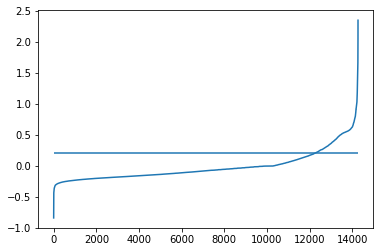

Number of cells in each class: 
0 <---> Granule-immature    1333
1 <---> Granule-mature      1712
2 <---> Neuroblast_1          97
3 <---> Neuroblast_2         777
4 <---> nIPC                  88
dtype: int64


In [3]:
from VITAE import VITAE

# Clear the tf session if necessary, especially when rerunning the model. 
# tf.keras.backend.clear_session() 

# Here we set random seed to reproduce the results on the same 
# computer/machine. Note that since floating-point computation 
# may be different on different computers, the results will be 
# slightly different and the errors are accumulated during training. 
# Refer to https://github.com/tensorflow/tensorflow/issues/38197#issuecomment-637846372
# for more details about reproducibility issues of floating point computation.
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Using tf.float64 for training can alleviate this problem, 
# while it requires more computational resources.
tf.keras.backend.set_floatx('float64')


# create an instance
model = VITAE()

# fit in data
model.get_data(X = data['count'],             # count or expression matrix, (dense or sparse) numpy array 
               labels = data['grouping'],     # (optional) labels, which will be converted to string
               covariate=None,                # (optional) covariates
               gene_names=data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names=data['cell_ids']    # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'Gaussian',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

Or we can use `scanpy` to preprocess the data. Input `adata` to `get_data` function. This step uses Seurat processing as above.

In [ ]:
# Optional when scanpy is installed
# create an instance
model = VITAE()

# fit in data
model.get_data(adata = adata,                 # AnnData scanpy object 
               labels = data['grouping'],     # (optional) labels, which will be converted to string
               covariate=None,                # (optional) covariates
               gene_names=data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names=None                # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(processed = False,      # (optional) User can specify whether the AnnData has been processed, if so, Gaussian is applied
                      dimred = False,         # (optional) If the AnnData has been processed, user can specify whether the AnnData has been through dimension reduction, if not, PCA is applied
                      K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'UMI',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

# Build model

Now we are able to create the neural network.

In [4]:
model.build_model(dim_latent = 8,         # The size of the latent dimension
                  dimensions=[32]         # The size of each layer in the encoder between the input layer and the 
                                          # latent layer. The size of each layer in the decoder is the reverse.
                  )

# Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [5]:
model.pre_train(stratify = False,            # (Optional) use random (unstratified) shuffle splitting when it is 'False'. Set to 'None' to use 'model.labels'. Otherwise, an array need to be provided.
                test_size = 0.1,             # (Optional) the proportion or size of the test set.
                random_state = 0,            # (Optional) the random state of data splitting.
                learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
                batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
                L=1,                         # (Optional) the number of MC samples (the default is 1).
                alpha=0.01,                  # (Optional) the value of alpha in [0,1] to encourage covariate adjustment. Not used if there is no covariates.
                num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
                num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
                early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
                early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
                early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
                path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None).
                ) 

Pretrain - Start of epoch 0
15/15 [==============================] - 2s 159ms/step - Reconstructed Loss: 122.6079
 Training loss over epoch: 167.6652. Testing loss over epoch: 236.7659
Pretrain - Start of epoch 1
15/15 [==============================] - 0s 16ms/step - Reconstructed Loss: 184.6265
 Training loss over epoch: 159.4549. Testing loss over epoch: 222.8119
Pretrain - Start of epoch 2
15/15 [==============================] - 0s 15ms/step - Reconstructed Loss: 224.8105
 Training loss over epoch: 166.8852. Testing loss over epoch: 189.1659
Pretrain - Start of epoch 3
15/15 [==============================] - 0s 16ms/step - Reconstructed Loss: 137.7346
 Training loss over epoch: 149.8255. Testing loss over epoch: 185.3495
Pretrain - Start of epoch 4
15/15 [==============================] - 0s 14ms/step - Reconstructed Loss: 112.5652
 Training loss over epoch: 145.3250. Testing loss over epoch: 188.0704
Pretrain - Start of epoch 5
15/15 [==============================] - 0s 15ms/st

You can also save and load model weights by the following codes:

In [6]:
# save model weight
model.save_model(path_to_file='../weight/tutorial_dentate/dentate_Gaussian_pretrain.checkpoint')

# load model weight, which can build or re-build the network based on wieght file 
# model.load_model(path_to_file='weight/dentate_Gaussian_pretrain.checkpoint', # path to the weight file.
#                  load_labels=False                 # (Optional) whether to load clustering labels or not.
#                                                    # If load_labels is True, then the LatentSpace layer
#                                                    # will be initialized basd on the model. 
#                                                    # If load_labels is False, then the LatentSpace layer
#                                                    # will not be initialized.
#                 )

# Clustering and initialize latent structure

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

In [7]:
# Get latent representations of X after pre-training
z = model.get_latent_z()

# Assign pre-given labels to initialize the latent structure
# The object 'model.labels' is encoded as categorical data from 'model.label_names'.
labels = model.label_names    

We can plot the clusters to see how it looks like. We provide a function to do dimension reduction easily.

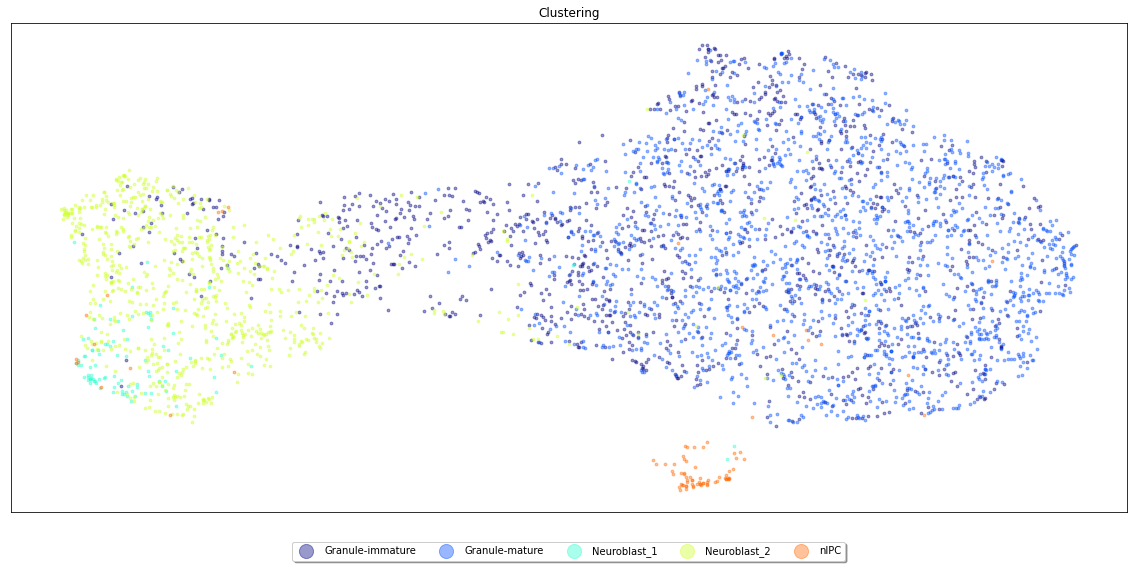

In [8]:
from VITAE import get_embedding
embed_z = get_embedding(z, 
                        dimred='umap', # 'umap', pca' and 'tsne'. Recommend to use umap for general data
                                       # as it is fast. Sometimes 'umap' will break points into separate
                                       # clusters, in such case 'tsne' is recommended while it is somehow 
                                       # slow. For simple data, 'pca' will be good enough.
                       # **kwargs, extra key-value argument for the dimension reduction algorithms
                       )
     
plot_clusters(embed_z, labels)

Suppose we want to select a subset of the cells. For example, we want to remove cluster '09' (which is encoded as 4), we can do:

```
cell_subsets = model.cell_names[labels != 'nIPC']
model.set_cell_subset(cell_subsets) 
# this will update the model variables 'selected_cell_subset' & 'selected_cell_subset_id',
# corresponding to cell names & cell ids respectively.
# However, if you do not select a subset, these two variables will also be initialzed to
# be include all cells.
labels = labels[model.selected_cell_subset_id]
z = z[model.selected_cell_subset_id,:]
```

Then the later operations, such as training and inference, will automatically only deal with the selected subset of cells. 

Now we need to determine $k$, either from prior information or clustering results. And we also need to initialze $\pi$ and $\mu$. 

- $\mu$: The user can provide $\mu$, the clustering centers. If not given, $\mu$ is initialized by the mean of each cluster corrsponding to the given clustering labels in latent space. If clustering labels are not given, $\mu$ is sampled from uniform $[-1,1]$.
- $\pi$: The user can provide $\pi=(\pi_{1,1},\cdots,\pi_{1,k},\pi_{2,2},\cdots,\pi_{2,k},\cdots, \pi_{k,k})\in\mathbb{R}^{1\times K}$, the prior proportion for each node and each edge. If not given, $\pi$ is uniformly initialized. 

In [9]:
NUM_CLUSTER = len(np.unique(labels))

model.init_latent_space(
    NUM_CLUSTER,                     # numebr of clusters
    cluster_labels=labels,           # (optional) clustering labels or their names for plotting
    mu=None,                         # (optional) initial mean
    log_pi=None                      # (optional) initial pi
)                   

In case we don't have labels, we could do Louvain clustering by the following codes. You can choose different resolution parameter to get satisfactory clustering results.

```
z = model.get_latent_z()
embed_z = umap.UMAP().fit_transform(z)
g = get_igraph(z)
labels = leidenalg_igraph(g, res = 0.6) 
plot_clusters(embed_z, labels)
print(np.unique(labels))
```

And we can also use estimated cluster labels from other algorithms and softwares.

# Train

Warmup:5
Start of epoch 0
15/15 [==============================] - 2s 136ms/step - loss_neg_E_nb: 94.8578 - loss_neg_E_pz: 44.4831 - loss_E_qzx   : -11.2576 - loss_total: 33.2255
 Training loss over epoch: 2830064.6009 (133.0063, 2830075.8585, -11.2576) Testing loss over epoch: 531220.5117 (194.8489, 265524.0890, -11.2576)


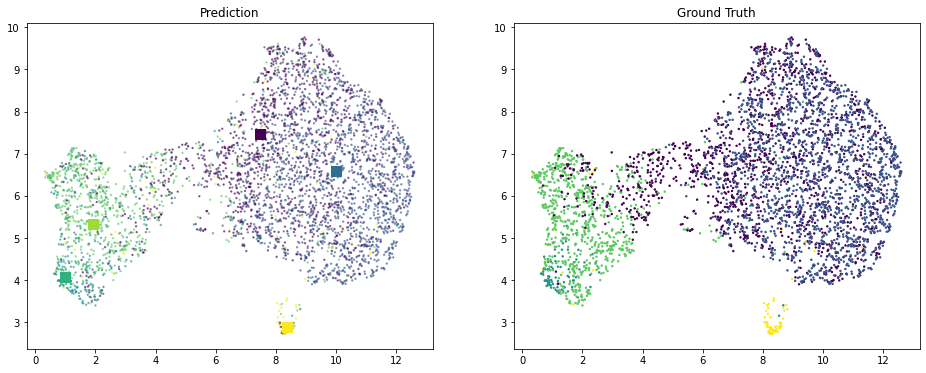

Start of epoch 1
15/15 [==============================] - 0s 18ms/step - loss_neg_E_nb: 156.3347 - loss_neg_E_pz: 2038.1641 - loss_E_qzx   : -11.2576 - loss_total: 2026.9065
 Training loss over epoch: 57013.4344 (133.6782, 57024.6920, -11.2576) Testing loss over epoch: 192486.6161 (182.9268, 96163.1022, -11.2576)
Start of epoch 2
15/15 [==============================] - 0s 18ms/step - loss_neg_E_nb: 195.0770 - loss_neg_E_pz: 33611032.1157 - loss_E_qzx   : -11.2576 - loss_total: 33611020.8581
 Training loss over epoch: 4011919.6121 (142.3073, 4011930.8697, -11.2576) Testing loss over epoch: 4757.1186 (166.2510, 2306.6914, -11.2576)
Start of epoch 3
15/15 [==============================] - 0s 18ms/step - loss_neg_E_nb: 122.4668 - loss_neg_E_pz: 650.0531 - loss_E_qzx   : -11.2576 - loss_total: 638.7955
 Training loss over epoch: 10929644.3694 (131.6667, 10929655.6270, -11.2576) Testing loss over epoch: 4316.2668 (169.1131, 2084.8344, -11.2576)
Start of epoch 4
15/15 [=====================

15/15 [==============================] - 0s 22ms/step - loss_neg_E_nb: 89.1515 - loss_neg_E_pz: 19.7117 - loss_E_qzx   : -10.9016 - loss_total: 106.7717
 Training loss over epoch: 341.5091 (91.9516, 135.6840, -10.9052) Testing loss over epoch: 209.2725 (129.3106, 50.8779, -10.8970)
Start of epoch 29
15/15 [==============================] - 0s 21ms/step - loss_neg_E_nb: 106.9950 - loss_neg_E_pz: 314.6029 - loss_E_qzx   : -10.8865 - loss_total: 714.4278
 Training loss over epoch: 305.4082 (90.2833, 118.4525, -10.8900) Testing loss over epoch: 302.0122 (123.4424, 100.1676, -10.8827)
Start of epoch 30
15/15 [==============================] - 0s 22ms/step - loss_neg_E_nb: 87.6975 - loss_neg_E_pz: 305.1485 - loss_E_qzx   : -10.8720 - loss_total: 676.2504
 Training loss over epoch: 7955.2720 (91.4226, 3942.8006, -10.8759) Testing loss over epoch: 138.3862 (116.2633, 21.9286, -10.8672)


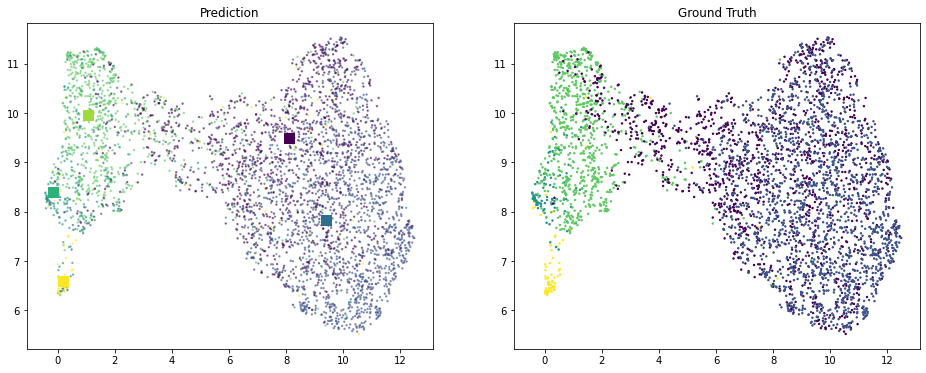

Start of epoch 31
15/15 [==============================] - 0s 22ms/step - loss_neg_E_nb: 88.8302 - loss_neg_E_pz: 21.2272 - loss_E_qzx   : -10.8570 - loss_total: 109.5708
 Training loss over epoch: 153.5891 (89.0496, 43.1301, -10.8604) Testing loss over epoch: 214.9980 (116.5490, 60.0776, -10.8531)
Start of epoch 32
15/15 [==============================] - 0s 22ms/step - loss_neg_E_nb: 79.7566 - loss_neg_E_pz: 21.7453 - loss_E_qzx   : -10.8436 - loss_total: 101.5600
 Training loss over epoch: 425.1731 (88.7361, 179.0655, -10.8469) Testing loss over epoch: 327.4345 (119.4967, 114.8086, -10.8397)
Start of epoch 33
15/15 [==============================] - 0s 21ms/step - loss_neg_E_nb: 81.8400 - loss_neg_E_pz: 18.0290 - loss_E_qzx   : -10.8309 - loss_total: 96.2361
 Training loss over epoch: 412.5992 (88.0103, 173.1283, -10.8339) Testing loss over epoch: 193.2583 (113.4920, 50.7105, -10.8273)
Start of epoch 34
15/15 [==============================] - 0s 22ms/step - loss_neg_E_nb: 69.8840 -

In [10]:
model.train(stratify = False,            # (Optional) use random (unstratified) shuffle splitting when it is 'False'. Set to 'None' to use 'model.labels'. Otherwise, an array need to be provided.
            test_size = 0.1,             # (Optional) the proportion or size of the test set.
            random_state = 0,            # (Optional) the random state of data splitting.
            learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
            batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
            L=1,                         # (Optional) the number of MC samples (the default is 1).
            alpha=0.01,                  # (Optional) the value of alpha in [0,1] to encourage covariate adjustment. Not used if there is no covariates.
            beta=2,                      # (Optional) the value of beta in beta-VAE.
            num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
            num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
            early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
            early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
            early_stopping_warmup=5,     # (Optional) the number of warmup epoches (the default is 0).
            path_to_weights=None,        # (Optional) the path of weight file to be saved; not saving weight if None (the default is None). 
            plot_every_num_epoch=30,     # (Optional) plot the intermediate result every few epoches, or not plotting if it is None.            
            dimred='umap'                # (Optional) the name of dimension reduction algorithms, can be 'umap', 'pca' and 'tsne'. Default is 'umap'. Only used if 'plot_every_num_epoch' is not None. 
            #**kwargs                    # (Optional ) extra key-value arguments for calling the dimension reduction algorithms.   
            )

In [11]:
# save model weight
model.save_model(path_to_file='../weight/tutorial_dentate/dentate_train.checkpoint')

# load model weight
# model.load_model(path_to_file='weight/dentate_train.checkpoint', # path to the weight file.
#                  load_labels=True
#                 )

# Inference

## Trajectory and Pseudotime

In [12]:
# initialze inference
model.init_inference(batch_size=64, 
                     L=100,            # L is the number of MC samples
                     dimred='umap',    # dimension reduction methods
                     #**kwargs         # extra key-value arguments for dimension reduction algorithms.    
                    ) 
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

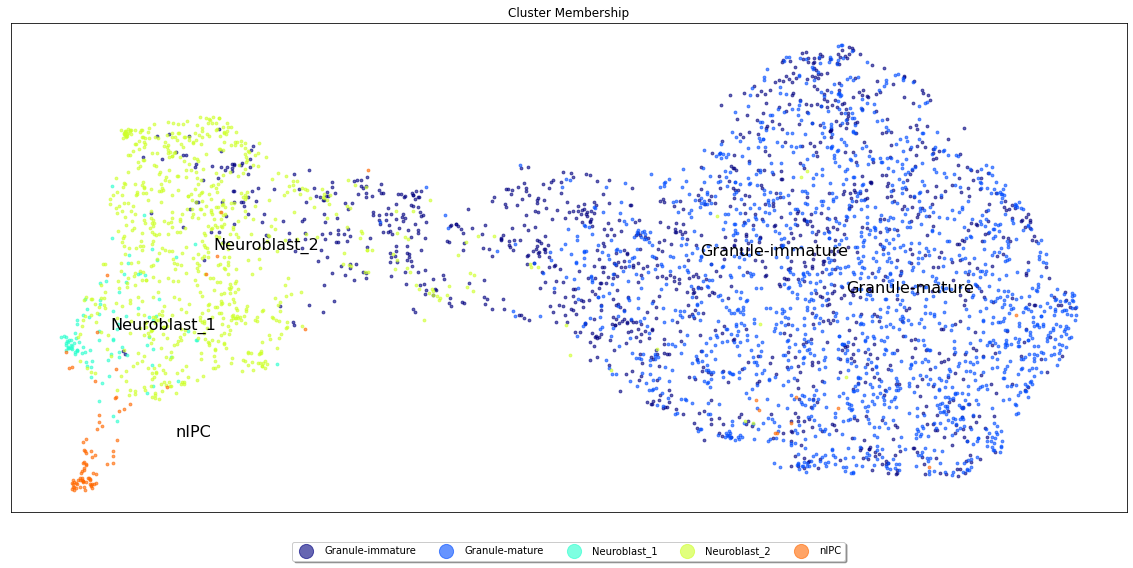

[[0.   0.08 0.   0.3  0.  ]
 [0.08 0.   0.   0.   0.  ]
 [0.   0.   0.   0.03 0.18]
 [0.3  0.   0.03 0.   0.  ]
 [0.   0.   0.18 0.   0.  ]]
[(0, 3), (0, 1), (2, 4), (2, 3)]


In [13]:
import networkx as nx
# compute inference score, and get umap embedding
# a plot of clustering result will be displayed
G = model.comp_inference_score(method='modified_map',  # 'mean', 'modified_mean', 'map', and 'modified_map'
                               thres=0.5,              # (Optional) threshold for compute the conditional probablity, only applies to 'mean' and 'modified_mean'
                               no_loop=True            # if no_loop=True, then find the maximum spanning tree
                               )           
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

Now, the user needs to provide the initial node for the trajectory.

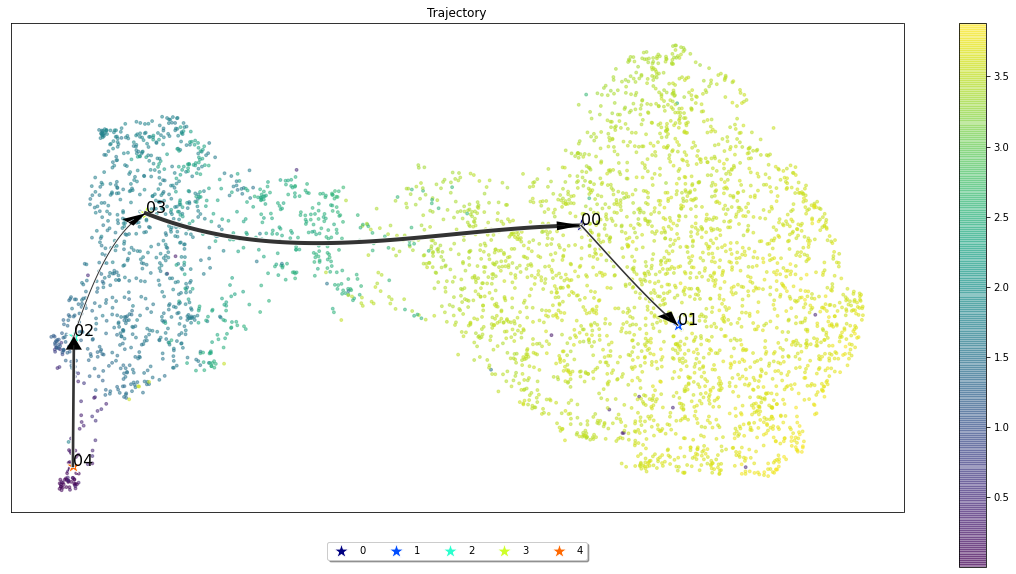

(<networkx.classes.graph.Graph at 0x7fa812d01d30>,
 array([[0.        , 0.        , 0.00545251, 0.        , 0.99454749],
        [0.        , 0.        , 0.2141733 , 0.        , 0.7858267 ],
        [0.        , 0.        , 0.0381035 , 0.        , 0.9618965 ],
        ...,
        [0.59669093, 0.40330907, 0.        , 0.        , 0.        ],
        [0.28980116, 0.71019884, 0.        , 0.        , 0.        ],
        [0.36327724, 0.63672276, 0.        , 0.        , 0.        ]]),
 array([0.00545251, 0.2141733 , 0.0381035 , ..., 3.40330907, 3.71019884,
        3.63672276]))

In [14]:
# Here we identify the 'begin_node_pred' as the one having minimum average 
# distance with the cells in the true begin node.
begin_node_true = model.le.transform([data['root_milestone_id']])[0]
begin_node_pred = int(np.argmin(np.mean((
                        model.z[model.labels[model.selected_cell_subset_id]==begin_node_true,:,np.newaxis] - 
                        model.mu[np.newaxis,:,:])**2, axis=(0,1))))
model.infer_trajectory(init_node=begin_node_pred,  # initial node for computing pseudotime.
                       cutoff=None                 # (Optional) cutoff score for edges (the default is 0.01).
                       )  

## Marker Genes

In [15]:
model.gene_names

array(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', ..., 'mt-Nd4',
       'mt-Nd5', 'mt-Nd6'], dtype='<U14')

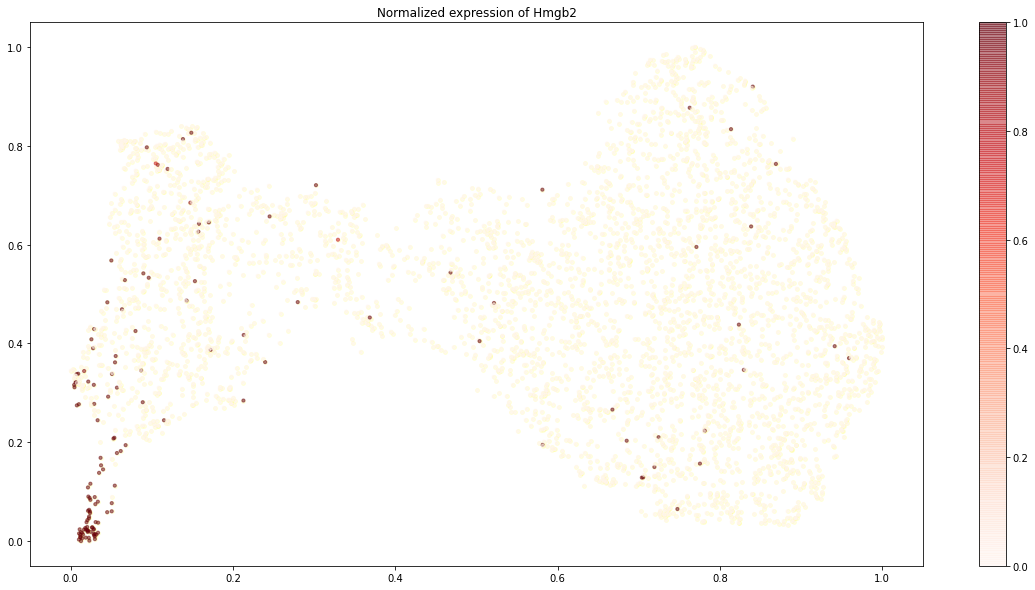

In [16]:
model.plot_marker_gene('Hmgb2')